## Bitcoin Allocation Strategies
Comparing different allocation strategies historically

. Lump-Sum

. Dollar Cost Averaging (DCA)

. Combination (optimized)

In [337]:
# Import Libraries
import pandas as pd
import numpy as np
import urllib
import requests
import riskfolio as rp
from datetime import datetime, timedelta
from copy import deepcopy

from highcharts import Highchart
from chart_builder import plot_chart, CHART_DEFAULTS
from IPython.display import display, HTML, display_html
import import_ipynb

# Chart libraries + settings
# plt.style.use('seaborn-whitegrid')
pd.options.mode.chained_assignment = None  # default='warn' - disable some pandas warnings
pd.options.display.float_format = '{:,.2f}'.format


In [338]:
# Load Bitcoin Prices into a dataframe
# Ticker is customizable
ticker = "BTC"
# Cryptocompare URL and fiels
base_url = 'https://min-api.cryptocompare.com/data/histoday'
ticker_field = 'fsym'
field_dict = {'tsym': 'USD','allData': 'true'}
# Convert the field dict into a url encoded string
url_args = "&" + urllib.parse.urlencode(field_dict)
ticker = ticker.upper()
globalURL = (base_url + "?" + ticker_field + "=" + ticker + url_args)

In [339]:
# Request the data
resp = requests.get(url=globalURL)
data = resp.json()
data["Response"]

'Success'

In [340]:
# Parse the JSON into a Pandas DataFrame
try:
    df = pd.DataFrame.from_dict(data['Data'])
    df = df.rename(columns={'time': 'date'})
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df.set_index('date', inplace=True)
    df_save = df[['close', 'open', 'high', 'low']]
except Exception as e:
    print(e)
    df_save = None

In [341]:
# Include percentage change 
df = df_save
df['change'] = df['close'].pct_change()

### Support Utilities to be used later

In [342]:
# Increment n number of months of certain date
def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and not y%400==0 else 28,31,30,31,30,31,31,30,31,30,31][m-1])
    new_date = (date.replace(day=d,month=m, year=y))
    return new_date

def add_periods(date, periods, frequency):
    if frequency.upper() == 'D' or 'DAY' in frequency.upper():
        return (date + timedelta(days=periods))
    if frequency.upper() == 'W' or 'WEEK' in frequency.upper():
        return (date + timedelta(days=periods * 7))
    if frequency.upper() == 'M' or 'MONTH' in frequency.upper():
        return(monthdelta(date, periods))
    if frequency.upper() == 'Y' or 'YEAR' in frequency.upper():
        return(monthdelta(date, periods * 12))
    
def annualization_factor(df):
    """
    Receives a df and returns the number of periods to apply
    to annualize the returns. For BTC this should be close to
    365 as it trades daily. For stocks should be close to 252.
    Args:
        df (_type_): _description_
    """
    start_date = df.index[0]
    end_date = df.index[-1]
    number_of_days = (end_date - start_date).days
    fraction_of_year = number_of_days / 365
    data_points = len(df)
    annualization_factor = data_points / fraction_of_year
    return int(round(annualization_factor, 0))


### Main Allocation Class
See example on creating an allocation instance at the cell following the class definition

In [343]:
class AllocationManager:
    def __init__(self):
        self.frequency = 'D'  # 'D', 'W', 'M', 'Y'
        self.allocation_periods = 30  # Assume allocation happens during 30 periods
        self.upfront_percent = 0  # [0 - 1]: amount to be allocated upfront
        self.capital = 100000  # 10,000 dollars to allocate
        self.df = df  # Bitcoin Prices Dataframe
        self.start_date = self.df.index.min()  # Date where allocation starts (default = first date)
                                               # ex: pd.to_datetime('2023-01-01', format='%Y-%m-%d')
        self.end_date = self.df.index.max()  # End date for analysis (default = today), but this can be used to test specific timeframes (ex: ending last year)
                                             # ex: pd.to_datetime('2023-01-01', format='%Y-%m-%d')
        # Create empty allocation & position columns
        self.df['allocation'] = 0
        self.df['BTC_tx'] = 0
        self.risk_free_rate = 0.05
         
    def allocate_capital(self):
        # TRIM THE DF between start and end dates
        # Filter the dataframe to only include selected dates
        self.df = self.df[(self.df.index >= (self.start_date)) & (self.df.index <= self.end_date)]
        
        # Clear allocation and other columns
        self.df['allocation'] = 0
        self.df['BTC_tx'] = 0
        self.df['BTC_position'] = 0
        self.df['portfolio_position'] = 0
        self.df['cum_capital'] = 0
        self.df['normalized_port_position'] = 0
        self.df['cum_return'] = 0
        
        # Updates the dataframe to allocate the capital
        current_date = self.start_date
        periods_left = self.allocation_periods
        
        # Set upfront amount if any & per period amounts
        if self.upfront_percent > 0:
            upfront = self.upfront_percent * self.capital  # how much upfront in $
            per_period = (self.capital - upfront) / (self.allocation_periods - 1)
        else:
            per_period = self.capital / self.allocation_periods 
            upfront = per_period
        
        # Start looping until allocation is complete
        while periods_left > 0:
            # Allocate Capital
            if current_date == self.start_date:
                self.df.at[current_date, 'allocation'] = upfront
            else:
                self.df.at[current_date, 'allocation'] = per_period
            
            # Allocate BTC
            self.df.at[current_date, 'BTC_tx'] = (
                self.df.at[current_date, 'allocation'] / 
                self.df.at[current_date, 'close'] 
                )
            current_date = add_periods(current_date, 1, self.frequency)
            if current_date > self.end_date:
                raise Exception("Allocation dates overflow end date. Either shorten the allocation period or increase the data range.")
            periods_left -= 1

        # Sum all BTC Txs and calculate portfolio values
        self.df['BTC_position'] = self.df['BTC_tx'].cumsum()
        self.df['portfolio_position'] = (self.df['BTC_position'] * self.df['close'])
        self.df = self.df.fillna(0)
        # TO DO ---------------------
        self.df['cum_capital'] = self.df['allocation'].cumsum()
        self.df['normalized_port_position'] = (self.df['portfolio_position'] / 
                                               self.df['cum_capital']) * 100
        self.df['cum_return'] = self.df['normalized_port_position'] / 100

    def show_allocations(self):
        al_df = self.df.where(self.df.allocation > 0).dropna()
        return (al_df)
        
    def stats(self):
        df = deepcopy(self.df)
        stats = {}
        stats = stats | deepcopy(self.__dict__)
        del stats['df'] 
        stats['capital allocated'] = df.allocation.sum()
        stats['BTC allocated'] = df.BTC_tx.sum()
        stats['max portfolio value'] = df.portfolio_position.max()
        stats['final portfolio value'] = df.portfolio_position[-1]
        # Calculate Return on Invested Capital
        stats['ROIC'] = (
            (stats['final portfolio value'] / 
             stats['capital allocated']) - 1
            )
        # Calculate Multiple of Invested Capital
        stats['MOIC'] = (
            (stats['final portfolio value'] / 
             stats['capital allocated'])
            )
        
        stats['number_points'] = df['change'].count()
        stats['volatility_daily'] = df['change'].std()
        stats['annualization_factor'] = annualization_factor(df)
        stats['volatility_annual'] = df['change'].std() * annualization_factor(df)**.5
        stats['return_annual'] = ((df['cum_return'][-1]) ** (annualization_factor(df) / df['change'].count())) -1
    
        stats['sharpe_ratio'] = (stats['return_annual'] -
                             self.risk_free_rate) / stats['volatility_annual']
        Y = df['normalized_port_position'].pct_change().dropna()
        stats['hist_VaR_95'] = rp.RiskFunctions.VaR_Hist(Y, alpha=0.05)
        stats['max_DD_abs'] = rp.RiskFunctions.MDD_Rel(Y)
        stats['avg_DD_abs'] = rp.RiskFunctions.ADD_Rel(Y)
        stats['DaR_DD_abs_95'] = rp.RiskFunctions.DaR_Rel(Y, alpha=0.05)
        # Bitcoin stats
        stats['BTC_initial'] = df['close'][0]
        stats['BTC_final'] = df['close'][-1]
        stats['BTC_MOIC'] = df['close'][-1] / df['close'][0]
        stats['BTC_period'] = (stats['BTC_final'] / stats['BTC_initial']) - 1
        
        # Compared to BTC - how much more or less $100 invested in the 
        # allocation strategy resulted compared to $100 in BTC
        stats['outperformance_DV100'] = (stats['MOIC'] * 100) - (stats['BTC_MOIC'] * 100)
        
        #  Cost Basis Statistics
        stats['weighted_avg_cost'] =  (stats['capital allocated'] / 
                                       stats['BTC allocated'])
        txs = self.show_allocations()
        stats['avg_buy_price'] = txs['close'].mean()
        stats['max_buy_price'] = txs['close'].max()
        stats['min_buy_price'] = txs['close'].min()
        stats['first_buy_price'] = txs['close'][0]
        stats['lump_sum_beats_avg'] = (stats['first_buy_price'] < stats['avg_buy_price'])
        # Compare the % difference in how many BTC lump sum and DCA represent
        stats['BTC_bought_with_dca'] = (self.capital / stats['avg_buy_price'])
        stats['BTC_bought_with_ls'] = (self.capital / stats['first_buy_price'])
        stats['BTC_bought_ls_over_dca'] =  (stats['BTC_bought_with_ls'] / 
                                            stats['BTC_bought_with_dca'])
        return (stats)
    
def run_through_time(alloc):
    # Do the same allocation for every start date 
    # in the dataframe. This basically shortens the dataframe by 1 day
    # on every loop and stores the results.
    # And stores the results in a new df with stats.
    
    # Stores initial values
    stats = {}
    stats['inputs'] = stats | deepcopy(alloc.__dict__)
    
    # Store allocations outputs
    stats['outputs'] = {}
    # Remove the df to save memory
    del stats['inputs']['df'] 
    tmp_alloc = deepcopy(alloc)  # Creates a copy of Alloc Instance

    results = []    
    # Will loop from start date until there aren't enough periods to allocate 
    while True:
        try:
            tmp_alloc.allocate_capital()
            results.append(tmp_alloc.stats())
            tmp_alloc.start_date = add_periods(tmp_alloc.start_date, 1, 'D')
        except Exception as e:
            break
    df = pd.DataFrame(results)
    
    # Create Outputs - sums, averages, depending on column
    stats['outputs']['number_of_allocations'] = df['frequency'].count()
    stats['outputs']['avg_BTC_allocated'] = df['BTC allocated'].mean()
    stats['outputs']['avg_lump_sum_beats_avg'] = df['lump_sum_beats_avg'].mean()
    stats['outputs']['avg_ROIC'] = df['ROIC'].mean()
    stats['outputs']['avg_sharpe'] = df['sharpe_ratio'].mean()
    stats['outputs']['avg_DD'] = df['avg_DD_abs'].mean()
    stats['outputs']['avg_DaR_DD_abs_95'] = df['DaR_DD_abs_95'].mean()
    stats['outputs']['avg_outperformance_DV100'] = df['outperformance_DV100'].mean()
    stats['outputs']['avg_BTC_bought_ls_over_dca'] = df['BTC_bought_ls_over_dca'].mean()
    
    return (df, stats)
        
        

In [344]:
# Create a sample Instance of the AllocationManager and test results
btc_alloc = AllocationManager()
btc_alloc.capital = 100000
btc_alloc.allocation_periods = 5
btc_alloc.frequency = 'W'
btc_alloc.start_date = pd.to_datetime('2017-01-01', format='%Y-%m-%d')
btc_alloc.upfront_percent = 0.50
btc_alloc.allocate_capital()

In [345]:
btc_alloc.df

,close,open,high,low,change,allocation,BTC_tx,BTC_position,portfolio_position,cum_capital,normalized_port_position,cum_return
date,,,,,,,,,,,,
2017-01-01,995.44,963.38,"1,001.61",956.10,0.03,50000,50.23,50.23,"50,000.00",50000,100.00,1.00
2017-01-02,"1,017.05",995.44,"1,031.68",990.20,0.02,0,0.00,50.23,"51,085.45",50000,102.17,1.02
2017-01-03,"1,033.30","1,017.05","1,035.47","1,006.53",0.02,0,0.00,50.23,"51,901.67",50000,103.80,1.04
2017-01-04,"1,135.41","1,033.30","1,148.54","1,022.32",0.10,0,0.00,50.23,"57,030.56",50000,114.06,1.14
2017-01-05,989.35,"1,135.41","1,150.63",874.53,-0.13,0,0.00,50.23,"49,694.11",50000,99.39,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21,"24,450.50","24,838.09","25,216.35","24,168.60",-0.02,0,0.00,106.60,"2,606,396.18",100000,"2,606.40",26.06
2023-02-22,"24,186.92","24,450.50","24,471.79","23,597.76",-0.01,0,0.00,106.60,"2,578,298.85",100000,"2,578.30",25.78
2023-02-23,"23,941.10","24,186.92","24,595.08","23,629.29",-0.01,0,0.00,106.60,"2,552,094.71",100000,"2,552.09",25.52


In [346]:
# Show statistics
btc_alloc.stats()

{'frequency': 'W',
 'allocation_periods': 5,
 'upfront_percent': 0.5,
 'capital': 100000,
 'start_date': Timestamp('2017-01-01 00:00:00'),
 'end_date': Timestamp('2023-02-25 00:00:00'),
 'risk_free_rate': 0.05,
 'capital allocated': 100000,
 'BTC allocated': 106.59889102416756,
 'max portfolio value': 7200663.413636238,
 'final portfolio value': 2450578.453998563,
 'ROIC': 23.50578453998563,
 'MOIC': 24.50578453998563,
 'number_points': 2247,
 'volatility_daily': 0.04094501278659705,
 'annualization_factor': 365,
 'volatility_annual': 0.7822533709192485,
 'return_annual': 0.6814003603344769,
 'sharpe_ratio': 0.8071558190826331,
 'hist_VaR_95': 0.06320768170673252,
 'max_DD_abs': 0.8329062742789146,
 'avg_DD_abs': 0.43112336773233473,
 'DaR_DD_abs_95': 0.7908949321004535,
 'BTC_initial': 995.44,
 'BTC_final': 22988.78,
 'BTC_MOIC': 23.094089046049987,
 'BTC_period': 22.094089046049987,
 'outperformance_DV100': 141.16954939356447,
 'weighted_avg_cost': 938.0960630943947,
 'avg_buy_price'

In [347]:
btc_alloc.df

,close,open,high,low,change,allocation,BTC_tx,BTC_position,portfolio_position,cum_capital,normalized_port_position,cum_return
date,,,,,,,,,,,,
2017-01-01,995.44,963.38,"1,001.61",956.10,0.03,50000,50.23,50.23,"50,000.00",50000,100.00,1.00
2017-01-02,"1,017.05",995.44,"1,031.68",990.20,0.02,0,0.00,50.23,"51,085.45",50000,102.17,1.02
2017-01-03,"1,033.30","1,017.05","1,035.47","1,006.53",0.02,0,0.00,50.23,"51,901.67",50000,103.80,1.04
2017-01-04,"1,135.41","1,033.30","1,148.54","1,022.32",0.10,0,0.00,50.23,"57,030.56",50000,114.06,1.14
2017-01-05,989.35,"1,135.41","1,150.63",874.53,-0.13,0,0.00,50.23,"49,694.11",50000,99.39,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21,"24,450.50","24,838.09","25,216.35","24,168.60",-0.02,0,0.00,106.60,"2,606,396.18",100000,"2,606.40",26.06
2023-02-22,"24,186.92","24,450.50","24,471.79","23,597.76",-0.01,0,0.00,106.60,"2,578,298.85",100000,"2,578.30",25.78
2023-02-23,"23,941.10","24,186.92","24,595.08","23,629.29",-0.01,0,0.00,106.60,"2,552,094.71",100000,"2,552.09",25.52


In [348]:
d, stats = run_through_time(btc_alloc)
stats

{'inputs': {'frequency': 'W',
  'allocation_periods': 5,
  'upfront_percent': 0.5,
  'capital': 100000,
  'start_date': Timestamp('2017-01-01 00:00:00'),
  'end_date': Timestamp('2023-02-25 00:00:00'),
  'risk_free_rate': 0.05},
 'outputs': {'number_of_allocations': 2212,
  'avg_BTC_allocated': 15.56076600143484,
  'avg_lump_sum_beats_avg': 0.5556057866184448,
  'avg_ROIC': 2.577230262384652,
  'avg_sharpe': 0.34988603319292694,
  'avg_DD': 0.36031414925076966,
  'avg_DaR_DD_abs_95': 0.6780492873930289,
  'avg_outperformance_DV100': -9.594741058088458,
  'avg_BTC_bought_ls_over_dca': 1.0349842498532402}}

In [349]:
d

,frequency,allocation_periods,upfront_percent,capital,start_date,end_date,risk_free_rate,capital allocated,BTC allocated,max portfolio value,...,outperformance_DV100,weighted_avg_cost,avg_buy_price,max_buy_price,min_buy_price,first_buy_price,lump_sum_beats_avg,BTC_bought_with_dca,BTC_bought_with_ls,BTC_bought_ls_over_dca
0,W,5,0.50,100000,2017-01-01,2023-02-25,0.05,100000,106.60,"7,200,663.41",...,141.17,938.10,910.17,995.44,821.17,995.44,False,109.87,100.46,0.91
1,W,5,0.50,100000,2017-01-02,2023-02-25,0.05,100000,105.30,"7,113,218.32",...,160.48,949.63,917.27,"1,017.05",827.34,"1,017.05",False,109.02,98.32,0.90
2,W,5,0.50,100000,2017-01-03,2023-02-25,0.05,100000,103.04,"6,960,086.39",...,143.91,970.52,939.31,"1,033.30",893.75,"1,033.30",False,106.46,96.78,0.91
3,W,5,0.50,100000,2017-01-04,2023-02-25,0.05,100000,100.99,"6,821,478.31",...,296.82,990.24,933.94,"1,135.41",785.43,"1,135.41",False,107.07,88.07,0.82
4,W,5,0.50,100000,2017-01-05,2023-02-25,0.05,100000,106.03,"7,162,563.42",...,113.99,943.09,922.84,"1,003.97",810.11,989.35,False,108.36,101.08,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,W,5,0.50,100000,2023-01-17,2023-02-25,0.05,100000,4.56,"113,227.89",...,-3.97,"21,936.37","22,472.99","23,252.78","21,136.12","21,136.12",True,4.45,4.73,1.06
2208,W,5,0.50,100000,2023-01-18,2023-02-25,0.05,100000,4.54,"112,883.13",...,-6.69,"22,003.37","22,953.72","24,332.21","20,678.47","20,678.47",True,4.36,4.84,1.11
2209,W,5,0.50,100000,2023-01-19,2023-02-25,0.05,100000,4.55,"113,059.48",...,-4.40,"21,969.05","22,580.60","23,533.22","21,082.28","21,082.28",True,4.43,4.74,1.07
2210,W,5,0.50,100000,2023-01-20,2023-02-25,0.05,100000,4.37,"108,450.37",...,-1.00,"22,902.73","23,080.86","24,578.28","21,634.86","22,676.20",True,4.33,4.41,1.02


In [350]:
# Create summary HTML table
heading = f'<h1>Summary Results for DCA</h1>'
display(HTML(heading))
        
table_stats = f"""
        <h3>Inputs</h3>
        <table>
        <thead>
        """

for key, value in stats['inputs'].items():
    table_stats += f"""
            <tr>
                <td style='text-align: left;'>
                {key}
                </td>
                <td style='text-align: right;'>
                {value}
                </td>
            </tr>       
            """

table_stats += f"""
        </thead>
        </table>
        """
display(HTML(table_stats))


table_stats = f"""
        <h3>Outputs</h3>
        <table>
        <thead>
        """

for key, value in stats['outputs'].items():
    table_stats += f"""
            <tr>
                <td style='text-align: left;'>
                {key}
                </td>
                <td style='text-align: right;'>
                {"{0:,.2f}".format(value)}
                </td>
            </tr>       
            """

table_stats += f"""
        </thead>
        </table>
        """


        
display(HTML(table_stats))
        

# Chart Outperformance along time
# dates need to be in Epoch time for Highcharts
df_chart = deepcopy(d)
df_chart['start_date'] = (df_chart['start_date'] - datetime(1970, 1, 1)).astype(np.int64)
df_chart['start_date'] = (df_chart['start_date'] / 1000000).astype(np.int64)
x = df_chart['start_date'].to_list()
y = df_chart['outperformance_DV100'].to_list()
plot_chart(x, y, 'dates', 'outperformance', 'bar', 'outperf', 'Outperformance of $100 invested lumpsum compared to cost average')


frequency,W
allocation_periods,5
upfront_percent,0.5
capital,100000
start_date,2017-01-01 00:00:00
end_date,2023-02-25 00:00:00
risk_free_rate,0.05


number_of_allocations,"2,212.00"
avg_BTC_allocated,15.56
avg_lump_sum_beats_avg,0.56
avg_ROIC,2.58
avg_sharpe,0.35
avg_DD,0.36
avg_DaR_DD_abs_95,0.68
avg_outperformance_DV100,-9.59
avg_BTC_bought_ls_over_dca,1.03


In [351]:
# Show only the allocation periods
al_df = btc_alloc.show_allocations()
display(al_df)
# Check it adds to allocation amount
print("Total allocation:")
print(round(al_df.allocation.sum(), 8))
if (round(al_df.allocation.sum(), 8) == round(btc_alloc.capital, 8)):
    print ("Checks [OK]")
else:
    print ("[ERROR] - something went wrong")

,close,open,high,low,change,allocation,BTC_tx,BTC_position,portfolio_position,cum_capital,normalized_port_position,cum_return
date,,,,,,,,,,,,
2017-01-01,995.44,963.38,"1,001.61",956.10,0.03,"50,000.00",50.23,50.23,"50,000.00","50,000.00",100.00,1.00
2017-01-08,900.86,888.87,936.13,875.85,0.01,"12,500.00",13.88,64.10,"57,749.34","62,500.00",92.40,0.92
2017-01-15,821.17,819.63,826.43,808.63,0.00,"12,500.00",15.22,79.33,"65,140.84","75,000.00",86.85,0.87
2017-01-22,918.84,919.84,938.38,888.62,-0.00,"12,500.00",13.60,92.93,"85,388.69","87,500.00",97.59,0.98
2017-01-29,914.55,918.51,922.40,912.68,-0.00,"12,500.00",13.67,106.60,"97,490.02","100,000.00",97.49,0.97


Total allocation:
100000.0
Checks [OK]


### Run Simulations
Create different allocation scenarios

In [352]:
# CONSTANTS
# Define some static variables that will remain constant

# --------------
# Start Date
# --------------
# Data from 2010 has less meaning than recent data. For this analysis we can use
# more recent data. Using only data since 2017.
sim_start_date = pd.to_datetime('2017-01-01', format='%Y-%m-%d')

# Assuming $100,000 to be allocated
sim_allocated_capital = 10000

# Risk Free Rate (used to calculate sharpe ratio)
sim_risk_free_rate = 0.05


In [353]:
# Variables
# These will be the ranges / variables to be simulated

sim_frequencies = ['D', 'W', 'M']
sim_allocation_periods = {
    'D': [10, 15, 30],
    'W': [4, 8],
    'M': [6, 12]
}
sim_upfront_percents = [0, 0.25, 1]

In [354]:
# Loop to gather results
print("Running scenarios...")
sim_results =  []
full_df = pd.DataFrame()
for freq in sim_frequencies:
    for all in sim_allocation_periods[freq]:
        for upfr in sim_upfront_percents:
            # Create allocation instance
            sim_alloc = AllocationManager()
            sim_alloc.capital = sim_allocated_capital
            sim_alloc.allocation_periods = all
            sim_alloc.frequency = freq
            sim_alloc.start_date = sim_start_date
            sim_alloc.upfront_percent = upfr
            sim_alloc.allocate_capital()
            print('Running scenario: ' + str(freq) + ' ' + str(upfr) + ' ' + str(all))
            # Run this allocation through time
            tmp_df, stats = run_through_time(sim_alloc)
            full_df = pd.concat([full_df, tmp_df])
            sim_results.append(stats['inputs'] | stats['outputs'])

sim_df = pd.DataFrame(sim_results)

Running scenarios...
Running scenario: D 0 10
Running scenario: D 0.25 10
Running scenario: D 1 10
Running scenario: D 0 15
Running scenario: D 0.25 15
Running scenario: D 1 15
Running scenario: D 0 30
Running scenario: D 0.25 30
Running scenario: D 1 30
Running scenario: W 0 4
Running scenario: W 0.25 4
Running scenario: W 1 4
Running scenario: W 0 8
Running scenario: W 0.25 8
Running scenario: W 1 8
Running scenario: M 0 6
Running scenario: M 0.25 6
Running scenario: M 1 6
Running scenario: M 0 12
Running scenario: M 0.25 12
Running scenario: M 1 12


In [355]:
sim_results

[{'frequency': 'D',
  'allocation_periods': 10,
  'upfront_percent': 0,
  'capital': 10000,
  'start_date': Timestamp('2017-01-01 00:00:00'),
  'end_date': Timestamp('2023-02-25 00:00:00'),
  'risk_free_rate': 0.05,
  'number_of_allocations': 2237,
  'avg_BTC_allocated': 1.5654553408188887,
  'avg_lump_sum_beats_avg': 0.5561019222172553,
  'avg_ROIC': 2.5987908429910456,
  'avg_sharpe': 0.38199004676061576,
  'avg_DD': 0.35795652273184375,
  'avg_DaR_DD_abs_95': 0.6724150541591273,
  'avg_outperformance_DV100': -4.458561678611549,
  'avg_BTC_bought_ls_over_dca': 1.01029765400327},
 {'frequency': 'D',
  'allocation_periods': 10,
  'upfront_percent': 0.25,
  'capital': 10000,
  'start_date': Timestamp('2017-01-01 00:00:00'),
  'end_date': Timestamp('2023-02-25 00:00:00'),
  'risk_free_rate': 0.05,
  'number_of_allocations': 2237,
  'avg_BTC_allocated': 1.5686877594731279,
  'avg_lump_sum_beats_avg': 0.5561019222172553,
  'avg_ROIC': 2.606221779122065,
  'avg_sharpe': 0.3870770115039016,


In [356]:
sim_df

,frequency,allocation_periods,upfront_percent,capital,start_date,end_date,risk_free_rate,number_of_allocations,avg_BTC_allocated,avg_lump_sum_beats_avg,avg_ROIC,avg_sharpe,avg_DD,avg_DaR_DD_abs_95,avg_outperformance_DV100,avg_BTC_bought_ls_over_dca
0,D,10,0.00,10000,2017-01-01,2023-02-25,0.05,2237,1.57,0.56,2.60,0.38,0.36,0.67,-4.46,1.01
1,D,10,0.25,10000,2017-01-01,2023-02-25,0.05,2237,1.57,0.56,2.61,0.39,0.36,0.67,-3.72,1.01
2,D,10,1.00,10000,2017-01-01,2023-02-25,0.05,2237,1.58,0.00,2.64,0.43,0.36,0.67,0.00,1.00
3,D,15,0.00,10000,2017-01-01,2023-02-25,0.05,2232,1.56,0.56,2.58,0.36,0.36,0.67,-7.23,1.02
4,D,15,0.25,10000,2017-01-01,2023-02-25,0.05,2232,1.56,0.56,2.59,0.37,0.36,0.67,-5.81,1.02
5,D,15,1.00,10000,2017-01-01,2023-02-25,0.05,2232,1.59,0.00,2.65,0.43,0.36,0.68,0.00,1.00
6,D,30,0.00,10000,2017-01-01,2023-02-25,0.05,2217,1.53,0.55,2.51,0.32,0.36,0.67,-15.82,1.04
7,D,30,0.25,10000,2017-01-01,2023-02-25,0.05,2217,1.54,0.55,2.54,0.33,0.36,0.68,-12.27,1.04
8,D,30,1.00,10000,2017-01-01,2023-02-25,0.05,2217,1.60,0.00,2.67,0.43,0.36,0.68,0.00,1.00
9,W,4,0.00,10000,2017-01-01,2023-02-25,0.05,2219,1.54,0.55,2.55,0.34,0.36,0.68,-11.40,1.03


In [357]:
full_df = full_df.reset_index()
full_df['type'] = full_df['frequency'] + '_' + full_df['allocation_periods'].astype(str) + '_' + full_df['upfront_percent'].astype(str) 
full_df 

,index,frequency,allocation_periods,upfront_percent,capital,start_date,end_date,risk_free_rate,capital allocated,BTC allocated,...,weighted_avg_cost,avg_buy_price,max_buy_price,min_buy_price,first_buy_price,lump_sum_beats_avg,BTC_bought_with_dca,BTC_bought_with_ls,BTC_bought_ls_over_dca,type
0,0,D,10,0.00,10000,2017-01-01,2023-02-25,0.05,"10,000.00",10.43,...,958.98,965.06,"1,135.41",886.16,995.44,False,10.36,10.05,0.97,D_10_0.0
1,1,D,10,0.00,10000,2017-01-02,2023-02-25,0.05,"10,000.00",10.70,...,934.90,944.06,"1,135.41",785.43,"1,017.05",False,10.59,9.83,0.93,D_10_0.0
2,2,D,10,0.00,10000,2017-01-03,2023-02-25,0.05,"10,000.00",10.95,...,913.45,923.36,"1,135.41",785.43,"1,033.30",False,10.83,9.68,0.89,D_10_0.0
3,3,D,10,0.00,10000,2017-01-04,2023-02-25,0.05,"10,000.00",11.19,...,893.49,902.52,"1,135.41",785.43,"1,135.41",False,11.08,8.81,0.79,D_10_0.0
4,4,D,10,0.00,10000,2017-01-05,2023-02-25,0.05,"10,000.00",11.53,...,867.19,870.94,989.35,785.43,989.35,False,11.48,10.11,0.88,D_10_0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45118,1877,M,12,1.00,10000,2022-02-21,2023-02-25,0.05,"10,000.00",0.27,...,"37,037.39","37,037.39","37,037.39","37,037.39","37,037.39",False,0.27,0.27,1.00,M_12_1.0
45119,1878,M,12,1.00,10000,2022-02-22,2023-02-25,0.05,"10,000.00",0.26,...,"38,267.75","38,267.75","38,267.75","38,267.75","38,267.75",False,0.26,0.26,1.00,M_12_1.0
45120,1879,M,12,1.00,10000,2022-02-23,2023-02-25,0.05,"10,000.00",0.27,...,"37,270.85","37,270.85","37,270.85","37,270.85","37,270.85",False,0.27,0.27,1.00,M_12_1.0
45121,1880,M,12,1.00,10000,2022-02-24,2023-02-25,0.05,"10,000.00",0.26,...,"38,353.62","38,353.62","38,353.62","38,353.62","38,353.62",False,0.26,0.26,1.00,M_12_1.0


In [358]:
full_df.columns

Index(['index', 'frequency', 'allocation_periods', 'upfront_percent',
       'capital', 'start_date', 'end_date', 'risk_free_rate',
       'capital allocated', 'BTC allocated', 'max portfolio value',
       'final portfolio value', 'ROIC', 'MOIC', 'number_points',
       'volatility_daily', 'annualization_factor', 'volatility_annual',
       'return_annual', 'sharpe_ratio', 'hist_VaR_95', 'max_DD_abs',
       'avg_DD_abs', 'DaR_DD_abs_95', 'BTC_initial', 'BTC_final', 'BTC_MOIC',
       'BTC_period', 'outperformance_DV100', 'weighted_avg_cost',
       'avg_buy_price', 'max_buy_price', 'min_buy_price', 'first_buy_price',
       'lump_sum_beats_avg', 'BTC_bought_with_dca', 'BTC_bought_with_ls',
       'BTC_bought_ls_over_dca', 'type'],
      dtype='object')

In [359]:
sim_df.to_excel("output.xlsx") 

In [360]:
# Average Outperformance LS over DCA (all data)
print(full_df['BTC_bought_ls_over_dca'].mean())
print(full_df['start_date'].min())

1.098773681021606
2017-01-01 00:00:00


In [360]:
# MatPlotLib settings
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler
# Swan Colors
swan_colors = ['#31597F', '#7B96B0', '#C3D9E9', '#DAE1E8']
mpl.rcParams['lines.color'] = '#31597F'
mpl.rcParams['text.color'] = '#31597F'
mpl.rcParams['axes.prop_cycle'] = cycler(color=swan_colors)
mpl.rcParams['lines.linewidth'] = 1
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
sns.color_palette('pastel')
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=8)   
plt.rc('xtick', labelsize=8, color='#00305E')  
plt.rc('ytick', labelsize=8, color='#00305E')    
plt.rc('legend', fontsize=12)
plt.rc('font', size=8)          
plt.figure(figsize=(10, 4), tight_layout=True)

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

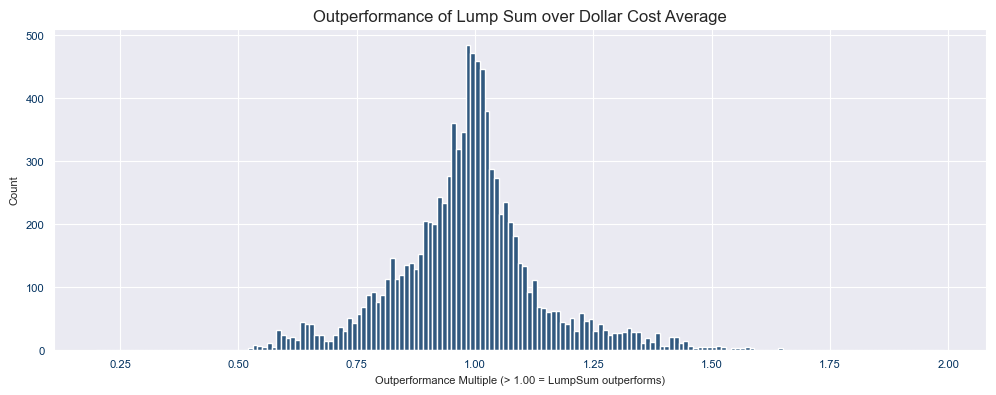

In [388]:
# Distribution of Over / underperformance
cust_bins = range(200, 2000, 10)
cust_bins = [x / 1000 for x in cust_bins]
plt.figure(figsize=(10, 4), tight_layout=True)

# Remove 1.00 to clean dataset
t_df = full_df.loc[full_df['BTC_bought_ls_over_dca'] != 1]

# Filter dates
start_date = pd.to_datetime('2021-01-01', format='%Y-%m-%d')
# end_date = pd.to_datetime('2023-01-01', format='%Y-%m-%d')
t_df = t_df.loc[full_df['start_date'] >= start_date]


chart = t_df['BTC_bought_ls_over_dca'].hist(bins=cust_bins, linewidth=1)
title = 'Outperformance of Lump Sum over Dollar Cost Average'
subtitle = 'Outperformance Multiple (> 1.00 = LumpSum outperforms)'
plt.title(title)
plt.xlabel(subtitle)
plt.ylabel('Count')
plt.show()


/var/folders/dv/t5p9gs7d27dbtm0x8l0kvf600000gq/T/ipykernel_30082/2637017228.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  barplot = t_df.groupby(['type'], as_index=False).mean()[['BTC_bought_ls_over_dca', 'type']]


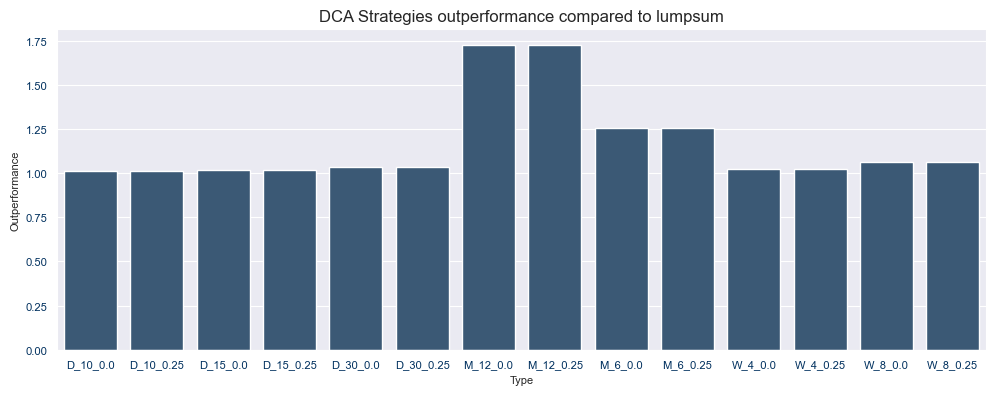

In [362]:
plt.figure(figsize=(10, 4), tight_layout=True)

customPalette = sns.color_palette(swan_colors, 1)

# Remove 1.00 to clean dataset
t_df = full_df.loc[full_df['BTC_bought_ls_over_dca'] != 1]

barplot = t_df.groupby(['type'], as_index=False).mean()[['BTC_bought_ls_over_dca', 'type']]
ax = sns.barplot(x=barplot['type'], y=barplot['BTC_bought_ls_over_dca'], palette=customPalette)

ax.set(title='DCA Strategies outperformance compared to lumpsum', xlabel='Type', ylabel='Outperformance')
plt.show()

In [391]:
t_df.to_csv('DCA.csv')

/var/folders/dv/t5p9gs7d27dbtm0x8l0kvf600000gq/T/ipykernel_30082/1813038717.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  barplot = t_df.groupby(['type'], as_index=False).mean()[['BTC_bought_ls_over_dca', 'type']]


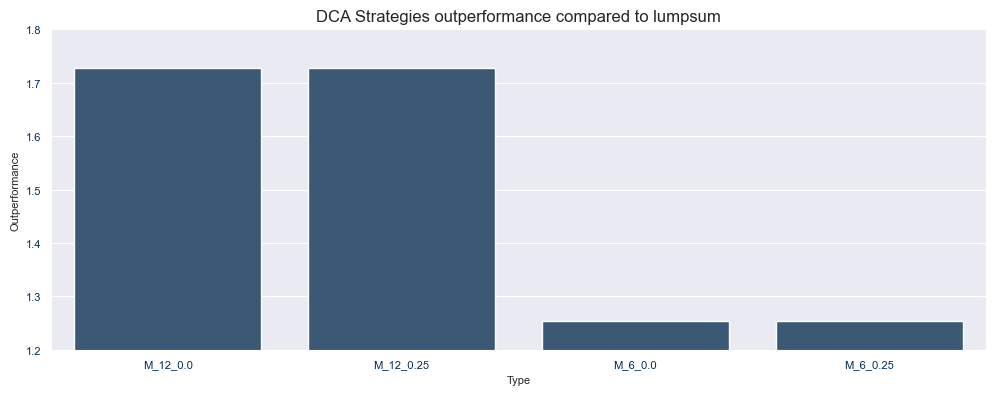

In [363]:
plt.figure(figsize=(10, 4), tight_layout=True)

customPalette = sns.color_palette(swan_colors, 1)

# Remove 1.00 to clean dataset
t_df = full_df.loc[full_df['BTC_bought_ls_over_dca'] != 1]

barplot = t_df.groupby(['type'], as_index=False).mean()[['BTC_bought_ls_over_dca', 'type']]
daily_plot = barplot[barplot['type'].str.contains("M")]
ax = sns.barplot(x=daily_plot['type'], y=daily_plot['BTC_bought_ls_over_dca'], palette=customPalette)

ax.set(title='DCA Strategies outperformance compared to lumpsum', xlabel='Type', ylabel='Outperformance')
ax.set(ylim=(1.20, 1.80))
plt.show()

In [364]:
full_df['type'].unique()

array(['D_10_0.0', 'D_10_0.25', 'D_10_1.0', 'D_15_0.0', 'D_15_0.25',
       'D_15_1.0', 'D_30_0.0', 'D_30_0.25', 'D_30_1.0', 'W_4_0.0',
       'W_4_0.25', 'W_4_1.0', 'W_8_0.0', 'W_8_0.25', 'W_8_1.0', 'M_6_0.0',
       'M_6_0.25', 'M_6_1.0', 'M_12_0.0', 'M_12_0.25', 'M_12_1.0'],
      dtype=object)

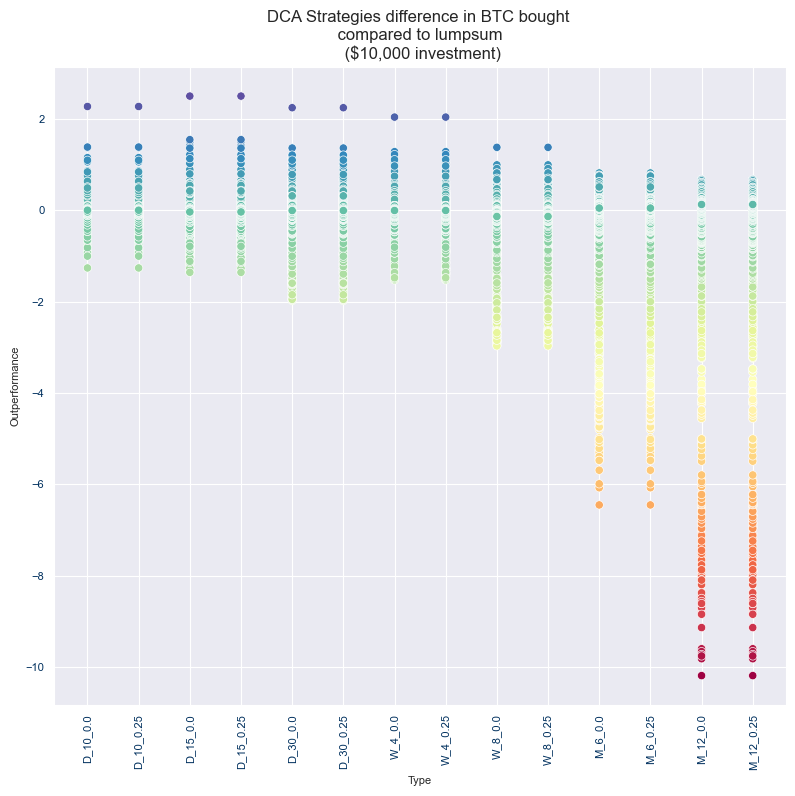

In [380]:
tdf  = full_df[~full_df['type'].str.contains("_1.0")]
tdf['diff'] = tdf['BTC_bought_with_dca'] - tdf['BTC_bought_with_ls']
plt.figure(figsize=(8, 8), tight_layout=True)
ax = sns.scatterplot(x=tdf['type'], y=tdf['diff'],
                hue=tdf['diff'],
                sizes=(10,700),
                palette='Spectral')
ax.set(title='DCA Strategies difference in BTC bought \n compared to lumpsum \n ($10,000 investment)', 
       xlabel='Type', ylabel='Outperformance')
plt.legend([],[], frameon=False)
plt.xticks(rotation=90)
plt.show()

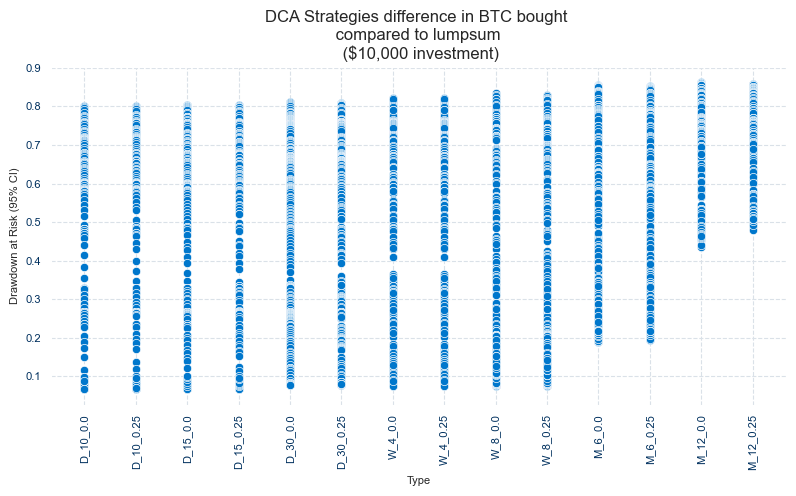

In [407]:
tdf  = full_df[~full_df['type'].str.contains("_1.0")]
tdf['diff'] = tdf['BTC_bought_with_dca'] - tdf['BTC_bought_with_ls']
plt.figure(figsize=(8, 5), tight_layout=True)
ax = sns.scatterplot(x=tdf['type'], y=tdf['DaR_DD_abs_95'],
                sizes=(10,500), color='#0077CC')
ax.set(title='DCA Strategies difference in BTC bought \n compared to lumpsum \n ($10,000 investment)', 
       xlabel='Type', ylabel='Drawdown at Risk (95% CI)')
ax.set_facecolor('white')
plt.grid(c='#DAE1E8', linestyle='--')
plt.legend([],[], frameon=False)
plt.xticks(rotation=90)
plt.savefig('dd_highres.eps', format='eps')
plt.show()

/var/folders/dv/t5p9gs7d27dbtm0x8l0kvf600000gq/T/ipykernel_30082/3838876353.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x=tdf['type'], y=tdf['volatility_annual'],


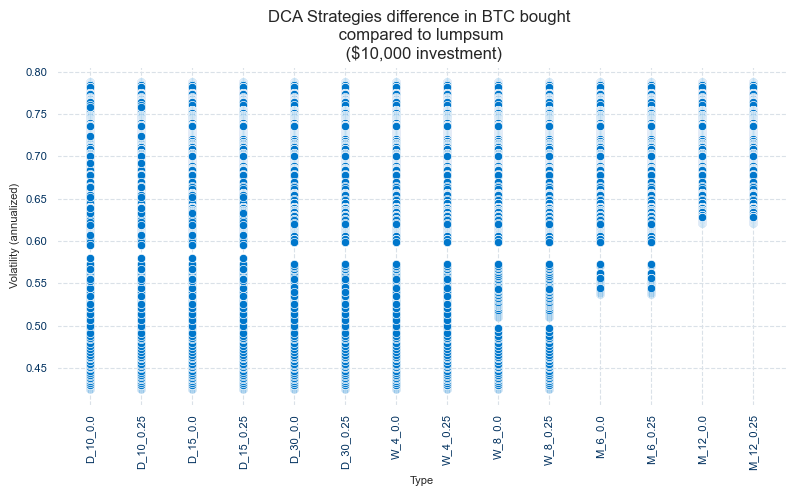

In [408]:
tdf  = full_df[~full_df['type'].str.contains("_1.0")]
tdf['diff'] = tdf['BTC_bought_with_dca'] - tdf['BTC_bought_with_ls']
plt.figure(figsize=(8, 5), tight_layout=True)
ax = sns.scatterplot(x=tdf['type'], y=tdf['volatility_annual'],
                color='#0077CC',
                sizes=(10,500),
                palette='Spectral')
ax.set(title='DCA Strategies difference in BTC bought \n compared to lumpsum \n ($10,000 investment)', 
       xlabel='Type', ylabel='Volatility (annualized)')
ax.set_facecolor('white')
plt.grid(c='#DAE1E8', linestyle='--')
plt.legend([],[], frameon=False)
plt.xticks(rotation=90)
plt.savefig('vol_highres.eps', format='eps')
plt.show()

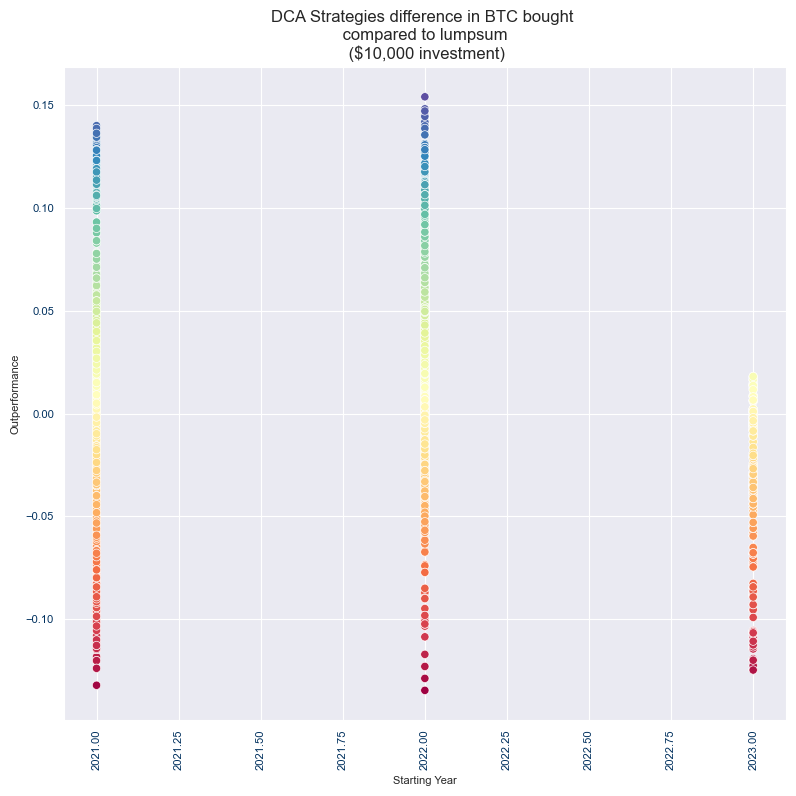

In [387]:
tdf  = full_df[~full_df['type'].str.contains("_1.0")]
tdf['diff'] = tdf['BTC_bought_with_dca'] - tdf['BTC_bought_with_ls']
tdf['year'] = tdf['start_date'].dt.year
tdf = tdf[tdf['year'] > 2020]
plt.figure(figsize=(8, 8), tight_layout=True)
ax = sns.scatterplot(x=tdf['year'], y=tdf['diff'],
                hue=tdf['diff'],
                sizes=(10,700),
                palette='Spectral')
ax.set(title='DCA Strategies difference in BTC bought \n compared to lumpsum \n ($10,000 investment)', 
       xlabel='Starting Year', ylabel='Outperformance')
plt.legend([],[], frameon=False)
plt.xticks(rotation=90)
plt.show()

# Data Analysis & Charts

## Optimization

In [366]:
# Minimize DV100
def optimize_allocation(allocation_periods):
    # print(allocation_periods)
    if allocation_periods < 2:
        return 100000000000
    opt_alloc = AllocationManager()
    opt_alloc.capital = 100000
    opt_alloc.allocation_periods = int(allocation_periods)
    opt_alloc.frequency = 'D'
    opt_alloc.start_date = pd.to_datetime('2018-01-01', format='%Y-%m-%d')
    opt_alloc.upfront_percent = 0
    opt_alloc.allocate_capital()
    d, stats = run_through_time(opt_alloc)
    # Maximize DV100
    return (stats['outputs']['avg_outperformance_DV100'] * -1)

from scipy.optimize import minimize_scalar

# res = minimize_scalar(optimize_allocation, method='brent', options={'disp':1})
# res.fun
# res.x

In [367]:
# Chart showing allocation periods results
allocs = range(2, 180, 8)
results_x = []
results_y = []
for alloc in allocs:
    results_x.append(alloc)
    results_y.append(optimize_allocation(alloc) * -1)

In [368]:
plot_chart(results_x, results_y, f'DCA Allocation # of Weeks (0% upfront)', 'outperformance', 'bar', 'outperf', 'Outperformance of $100 invested lumpsum compared to cost average (since Jan, 2017)', dt=False)